# import libraries

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# read dataset and clean it

In [2]:
df = pd.read_csv('diabetes.csv')
df.head(5).T

,0,1,2,3,4
Pregnancies,6.000,1.000,8.000,1.000,0.000
Glucose,148.000,85.000,183.000,89.000,137.000
BloodPressure,72.000,66.000,64.000,66.000,40.000
SkinThickness,35.000,29.000,0.000,23.000,35.000
Insulin,0.000,0.000,0.000,94.000,168.000
BMI,33.600,26.600,23.300,28.100,43.100
DiabetesPedigreeFunction,0.627,0.351,0.672,0.167,2.288
Age,50.000,31.000,32.000,21.000,33.000
Outcome,1.000,0.000,1.000,0.000,1.000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


count number of occurance of $0$s in columns

In [5]:
missing_info = {}
missing_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for column in missing_columns:
    zero_count = (df[column] == 0).sum()
    missing_percentage = (zero_count / df[column].shape[0]) * 100
    info_dict = {}
    info_dict['missing_count'] = zero_count
    info_dict['missing_percentage'] = missing_percentage
    missing_info[column] = info_dict

print("missing data count and percentage:\n")
missing_df = pd.DataFrame(missing_info)
missing_df

missing data count and percentage:



,Glucose,BloodPressure,SkinThickness,Insulin,BMI
missing_count,5.000000,35.000000,227.000000,374.000000,11.000000
missing_percentage,0.651042,4.557292,29.557292,48.697917,1.432292


replace 0s with NaN

In [6]:
for column in missing_columns:
    df[column] = df[column].replace(to_replace=0, value=np.nan)

count nan in each column

In [7]:
df.isnull().sum()


Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

# Imputations

Strategy A

In [8]:
df_strategy_A = df.copy()

imputers_strategy_A = {}
for column in missing_columns:
    imputers_strategy_A[column] = SimpleImputer(strategy='mean')

imputers_strategy_A

{'Glucose': SimpleImputer(),
 'BloodPressure': SimpleImputer(),
 'SkinThickness': SimpleImputer(),
 'Insulin': SimpleImputer(),
 'BMI': SimpleImputer()}

In [9]:
for column, imputer in imputers_strategy_A.items():
    df_strategy_A[[column]] = imputer.fit_transform(df_strategy_A[[column]])

In [10]:
df_strategy_A.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [11]:
print(f"mean of Glucose before imputation: {imputers_strategy_A['Glucose'].statistics_}")
print(f"mean of Glucose before imputation: {df[['Glucose']].mean()}")
print(f"mean of Glucose after imputation: {df_strategy_A[['Glucose']].mean()}")

mean of Glucose before imputation: [121.68676278]
mean of Glucose before imputation: Glucose    121.686763
dtype: float64
mean of Glucose after imputation: Glucose    121.686763
dtype: float64


## Why the mean stays the same

Let a column have:

* `n` non-NaN values with mean **μ**
* `k` NaN values

### Before imputation

The mean is computed over non-NaN values only:
$$
\mu = \frac{\sum x_i}{n}
$$

### After `SimpleImputer(strategy='mean')`

* Each NaN is replaced with **μ**
* New total sum:
  $$
  \sum x_i + k\mu
  $$
* New number of values: `n + k`

New mean:
$$
\frac{\sum x_i + k\mu}{n+k}
= \frac{n\mu + k\mu}{n+k}
= \mu
$$


Strategy B

In [12]:
df_strategy_B = df.copy()

imputers_strategy_B = {}
for column in missing_columns:
    imputers_strategy_B[column] = {'Outcome_0': SimpleImputer(strategy='mean'), 'Outcome_1': SimpleImputer(strategy='mean')}

imputers_strategy_B

{'Glucose': {'Outcome_0': SimpleImputer(), 'Outcome_1': SimpleImputer()},
 'BloodPressure': {'Outcome_0': SimpleImputer(), 'Outcome_1': SimpleImputer()},
 'SkinThickness': {'Outcome_0': SimpleImputer(), 'Outcome_1': SimpleImputer()},
 'Insulin': {'Outcome_0': SimpleImputer(), 'Outcome_1': SimpleImputer()},
 'BMI': {'Outcome_0': SimpleImputer(), 'Outcome_1': SimpleImputer()}}

In [13]:
outcome_0_mask = df_strategy_B['Outcome'] == 0
outcome_1_mask = df_strategy_B['Outcome'] == 1

for col in missing_columns:   
    # Impute for Outcome == 0
    df_strategy_B.loc[outcome_0_mask, col] = imputers_strategy_B[col]['Outcome_0']\
        .fit_transform(df_strategy_B.loc[outcome_0_mask, [col]])
    
    # Impute for Outcome == 1
    df_strategy_B.loc[outcome_1_mask, col] = imputers_strategy_B[col]['Outcome_1']\
        .fit_transform(df_strategy_B.loc[outcome_1_mask, [col]])

In [14]:
print(f"mean of Glucose for Outcome 0 before imputation: {imputers_strategy_B['Glucose']['Outcome_0'].statistics_}")
print(f"mean of Glucose for Outcome 1 before imputation: {imputers_strategy_B['Glucose']['Outcome_1'].statistics_}")
print(f"mean of Glucose after imputation: {df_strategy_B.loc[outcome_0_mask, ['Glucose']].mean()}")
print(f"mean of Glucose after imputation: {df_strategy_B.loc[outcome_1_mask, ['Glucose']].mean()}")

mean of Glucose for Outcome 0 before imputation: [110.64386318]
mean of Glucose for Outcome 1 before imputation: [142.31954887]
mean of Glucose after imputation: Glucose    110.643863
dtype: float64
mean of Glucose after imputation: Glucose    142.319549
dtype: float64


Strategy C

In [15]:
df_strategy_C = df.copy()

strategy_C_imputers = {}
for column in missing_columns:
    strategy_C_imputers[column] = KNNImputer(n_neighbors=5)

strategy_C_imputers

{'Glucose': KNNImputer(),
 'BloodPressure': KNNImputer(),
 'SkinThickness': KNNImputer(),
 'Insulin': KNNImputer(),
 'BMI': KNNImputer()}

In [16]:
for column, imputer in strategy_C_imputers.items():
    df_strategy_C[[column]] = imputer.fit_transform(df_strategy_C[[column]])

In [17]:
df_strategy_C.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Sure! Let’s break **KNN Imputation** down clearly. It’s a little different from mean/median imputation because it **uses other rows to estimate missing values**.

---

## 1️⃣ Core Idea

**KNN imputation** fills a missing value by looking at the **most similar rows** (neighbors) and averaging their values.

* "Similarity" = usually **Euclidean distance** (for numeric columns)
* Number of neighbors = **`n_neighbors` parameter** (default 5)

---

## 2️⃣ Step-by-Step Process

Let’s say a dataset:

| A   | B | C   |
| --- | - | --- |
| 1   | 5 | NaN |
| 2   | 6 | 3   |
| 1   | 4 | 2   |
| NaN | 5 | 1   |

We want to **impute `NaN` in row 1, column C**.

### Step 1: Find neighbors

* Compute distance **only on columns without NaN in the target row**
* Example: row 0 (`[1,5,NaN]`) → compare using columns `A` and `B` only
* Compute distance to other rows:

  * Row 1: `[2,6]` → distance = √((2-1)² + (6-5)²) = √2
  * Row 2: `[1,4]` → distance = √((1-1)² + (4-5)²) = 1
  * Row 3: `[NaN,5]` → cannot use A → may skip or use only B depending on settings

---

### Step 2: Select `k` nearest neighbors

* Suppose `n_neighbors = 2` → pick the 2 closest rows with non-missing C
* From above: rows 1 (`C=3`) and 2 (`C=2`)

---

### Step 3: Compute imputed value

* Default = **average of neighbors’ values** (weighted or unweighted)
  [
  C_{\text{imputed}} = \frac{3 + 2}{2} = 2.5
  ]

---

### Step 4: Replace missing value

* Row 0, column C → 2.5

---

## 3️⃣ Notes on sklearn implementation

```python
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3, weights='uniform')  # or 'distance'
X_imputed = imputer.fit_transform(X)
```

### Parameters:

| Parameter     | Meaning                                                               |
| ------------- | --------------------------------------------------------------------- |
| `n_neighbors` | Number of neighbors to consider                                       |
| `weights`     | `'uniform'` = simple mean, `'distance'` = closer neighbors count more |
| `metric`      | Distance metric, default `'nan_euclidean'`                            |

**`nan_euclidean`**:

* Computes distance ignoring columns where either row has NaN
* Ensures missing values don’t break distance calculation

---

## 4️⃣ Advantages

* Uses **correlation between columns** → more accurate than mean/median
* Can handle **mixed missing patterns**
* Can be **weighted** by distance

---

## 5️⃣ Disadvantages

* **Slow** on large datasets (needs distance calculation for each missing row)
* Works best for **numeric data**; categorical requires encoding
* Can be sensitive to **outliers**

---

## 6️⃣ Quick visual intuition

```
Row with NaN:  [ ?  ,  5 ,  ? ]
Neighbors:      [2, 6, 3], [1, 4, 2], [3,5,1]

Compute distance using available features → pick k nearest → fill missing with neighbor average
```




# Feature Engineering

Categorizing Glucose values

In [18]:
df_strategy_C['Glucose_cat'] = \
    pd.cut(df_strategy_C['Glucose'], bins=[0, 100, 125, np.inf], labels=['Normal', 'Prediabetes', 'Diabetic'])

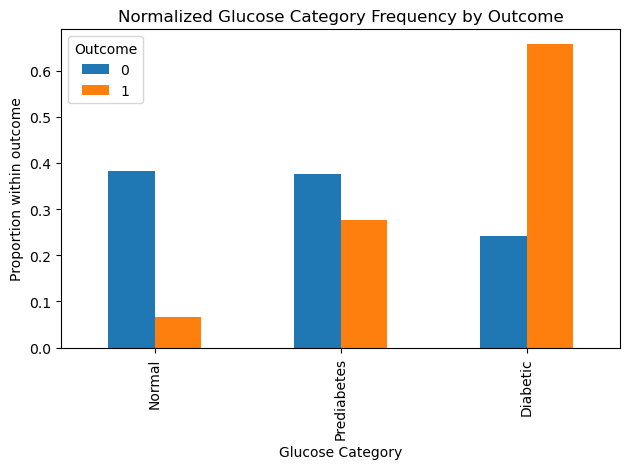

In [19]:
Glucose_cat_freq = (
    df_strategy_C
    .groupby("Outcome")["Glucose_cat"]
    .value_counts(normalize=True)
    .unstack(level=0)
)

# Ensure consistent category order
Glucose_cat_freq = Glucose_cat_freq.sort_index()

# Plot grouped bar chart
Glucose_cat_freq.plot(kind="bar")

plt.ylabel("Proportion within outcome")
plt.xlabel("Glucose Category")
plt.title("Normalized Glucose Category Frequency by Outcome")
plt.legend(title="Outcome")
plt.tight_layout()
plt.show()

Categorizing BMI

In [20]:
df_strategy_C['BMI_cat'] = \
    pd.cut(df_strategy_C['BMI'], bins=[0, 18.5, 25, 30, np.inf], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

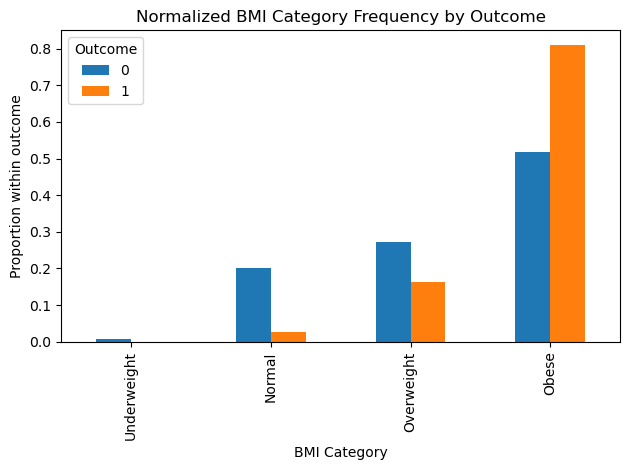

In [21]:
BMI_cat_freq = (
    df_strategy_C
    .groupby("Outcome")["BMI_cat"]
    .value_counts(normalize=True)
    .unstack(level=0)
)

# Ensure consistent category order
BMI_cat_freq = BMI_cat_freq.sort_index()

# Plot grouped bar chart
BMI_cat_freq.plot(kind="bar")

plt.ylabel("Proportion within outcome")
plt.xlabel("BMI Category")
plt.title("Normalized BMI Category Frequency by Outcome")
plt.legend(title="Outcome")
plt.tight_layout()
plt.show()

Categorizing age

In [22]:
df_strategy_C['Age_cat'] = \
    pd.cut(df_strategy_C['Age'], bins=[21, 30, 45, 60, np.inf], labels=['Young', 'Middle_Aged', 'Senior', 'Elderly'])

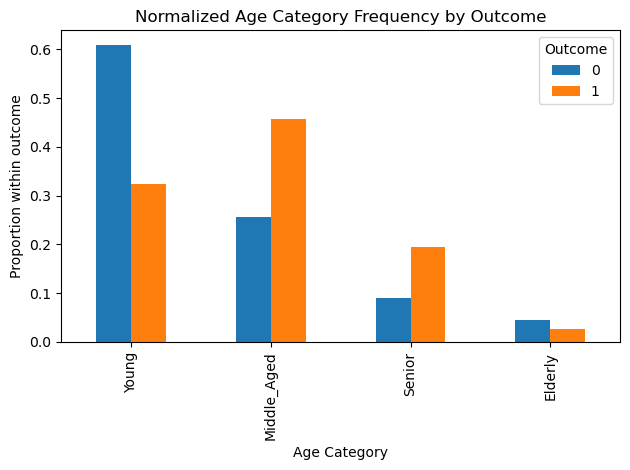

In [23]:
Age_cat_freq = (
    df_strategy_C
    .groupby("Outcome")["Age_cat"]
    .value_counts(normalize=True)
    .unstack(level=0)
)

# Ensure consistent category order
Age_cat_freq = Age_cat_freq.sort_index()

# Plot grouped bar chart
Age_cat_freq.plot(kind="bar")

plt.ylabel("Proportion within outcome")
plt.xlabel("Age Category")
plt.title("Normalized Age Category Frequency by Outcome")
plt.legend(title="Outcome")
plt.tight_layout()
plt.show()

Insulin to Glucose ratio

In [24]:
df_strategy_C['Insulin_to_Glucose_Ratio'] = df_strategy_C['Insulin'] / df_strategy_C['Glucose']

In [25]:
corr = df_strategy_C.corr(numeric_only=True)

In [26]:
corr['Outcome'].sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.492928
BMI                         0.311924
Age                         0.238356
Pregnancies                 0.221898
SkinThickness               0.215299
Insulin                     0.214411
DiabetesPedigreeFunction    0.173844
BloodPressure               0.166074
Insulin_to_Glucose_Ratio   -0.003815
Name: Outcome, dtype: float64

Weak neagtive corr which seems not informative

Categorizing blood pressure

In [27]:
df_strategy_C['BloodPressure_cat'] = \
    pd.cut(df_strategy_C['BloodPressure'], bins=[0, 80, 90, np.inf], labels=['Low', 'Normal', 'High'])

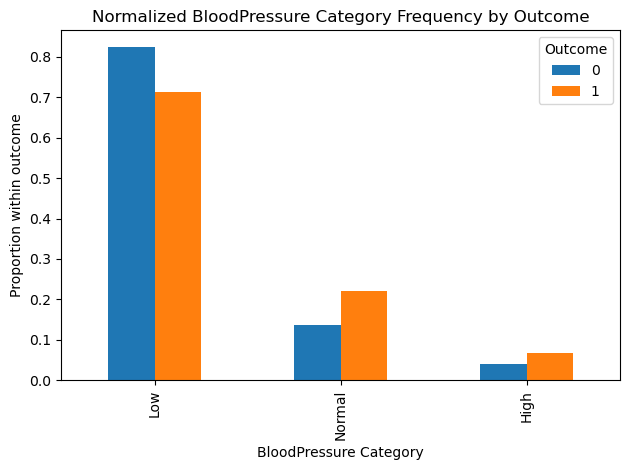

In [28]:
BloodPressure_cat_freq = (
    df_strategy_C
    .groupby("Outcome")["BloodPressure_cat"]
    .value_counts(normalize=True)
    .unstack(level=0)
)

# Ensure consistent category order
BloodPressure_cat_freq = BloodPressure_cat_freq.sort_index()

# Plot grouped bar chart
BloodPressure_cat_freq.plot(kind="bar")

plt.ylabel("Proportion within outcome")
plt.xlabel("BloodPressure Category")
plt.title("Normalized BloodPressure Category Frequency by Outcome")
plt.legend(title="Outcome")
plt.tight_layout()
plt.show()

# Train SVM model

Split train and test dataset

In [32]:
df_strategy_C.head(1).T

,0
Pregnancies,6
Glucose,148.0
BloodPressure,72.0
SkinThickness,35.0
Insulin,155.548223
BMI,33.6
DiabetesPedigreeFunction,0.627
Age,50
Outcome,1
Glucose_cat,Diabetic


In [33]:
df_strategy_C = df_strategy_C.drop(columns=['Glucose', 'BMI', 'Age', 'BloodPressure'])
df_strategy_C.head(1).T

,0
Pregnancies,6
SkinThickness,35.0
Insulin,155.548223
DiabetesPedigreeFunction,0.627
Outcome,1
Glucose_cat,Diabetic
BMI_cat,Obese
Age_cat,Senior
Insulin_to_Glucose_Ratio,1.051002
BloodPressure_cat,Low


In [35]:
df_strategy_C = df_strategy_C[['Pregnancies', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Glucose_cat', 'BMI_cat', 'Age_cat',
       'Insulin_to_Glucose_Ratio', 'BloodPressure_cat', 'Outcome']]

df_strategy_C.head(1).T

,0
Pregnancies,6
SkinThickness,35.0
Insulin,155.548223
DiabetesPedigreeFunction,0.627
Glucose_cat,Diabetic
BMI_cat,Obese
Age_cat,Senior
Insulin_to_Glucose_Ratio,1.051002
BloodPressure_cat,Low
Outcome,1


X = df_strategy_C.drop(columns=['Outcome'])
y = df_strategy_C['Outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

In [46]:
X_train.head()

,Pregnancies,SkinThickness,Insulin,DiabetesPedigreeFunction,Glucose_cat,BMI_cat,Age_cat,Insulin_to_Glucose_Ratio,BloodPressure_cat
353,1,12.00000,43.000000,0.580,Normal,Overweight,Young,0.477778,Low
711,5,27.00000,22.000000,0.439,Diabetic,Overweight,Middle_Aged,0.174603,Low
373,2,40.00000,94.000000,0.225,Prediabetes,Obese,Young,0.895238,Low
46,1,29.15342,155.548223,0.564,Diabetic,Overweight,Young,1.065399,Low
682,0,39.00000,105.000000,0.366,Normal,Obese,Young,1.105263,Low


In [47]:
y_train.head()

353    0
711    0
373    0
46     0
682    0
Name: Outcome, dtype: int64

create transformers

In [53]:
numeric_cols = X_train.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print(f"numeric_cols: {numeric_cols}")
print(f"categorical_cols: {categorical_cols}")

numeric_cols: ['Pregnancies', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Insulin_to_Glucose_Ratio']
categorical_cols: ['Glucose_cat', 'BMI_cat', 'Age_cat', 'BloodPressure_cat']


In [55]:
ohe_y = OneHotEncoder(
    handle_unknown='ignore'
)

# Fit on training labels only
y_train_ohe = ohe_y.fit_transform(y_train.to_numpy().reshape(-1, 1))

# Transform test labels
y_test_ohe = ohe_y.transform(y_test.to_numpy().reshape(-1, 1))

In [57]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


create three SVMs with three different kernels

In [62]:
svm_pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', SVC(probability=True, random_state=42))
    ]
)


param_grid = [
    # Linear SVM
    {
        'model__kernel': ['linear'],
        'model__C': [0.01, 0.1, 1, 10]
    },

    # Polynomial SVM
    {
        'model__kernel': ['poly'],
        'model__C': [0.1, 1, 10],
        'model__degree': [2, 3, 4],
        'model__gamma': ['scale', 'auto']
    },

    # RBF SVM
    {
        'model__kernel': ['rbf'],
        'model__C': [0.1, 1, 10],
        'model__gamma': ['scale', 'auto']
    }
]

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall',          # for binary classification
    'f1': 'f1',
    'precision': 'precision'
}


In [63]:
grid_search = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='f1',          # model selection metric
    cv=5,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)


fit grid search

In [64]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Pregnancies',
                                                                          'SkinThickness',
                                                                          'Insulin',
                                                                          'DiabetesPedigreeFunction',
                                                                          'Insulin_to_Glucose_Ratio']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Glucose_cat',
                                                                          'BMI_cat',
                                                                          'Age_cat',
                                                                          'BloodPressure_cat'])])),
                                       ('model',
                                        SVC(probability=True,
                                            r...
             param_grid=[{'model__C': [0.01, 0.1, 1, 10],
                          'model__kernel': ['linear']},
                         {'model__C': [0.1, 1, 10], 'model__degree': [2, 3, 4],
                          'model__gamma': ['scale', 'auto'],
                          'model__kernel': ['poly']},
                         {'model__C': [0.1, 1, 10],
                          'model__gamma': ['scale', 'auto'],
                          'model__kernel': ['rbf']}],
             refit='f1', return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'},
             verbose=2)

In [65]:
# Convert results to a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Display relevant columns
columns_of_interest = [
    'params', 
    'mean_test_accuracy', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1',
    'std_test_accuracy', 'std_test_precision', 'std_test_recall', 'std_test_f1'
]
print("Full Grid Search Results:")
print(results_df[columns_of_interest].sort_values(by='mean_test_f1', ascending=False))

# Print the best model
print("\nBest Model Based on F1 Score:")
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

# Optional: separate reports per kernel
kernels = ['linear', 'poly', 'rbf']
for kernel in kernels:
    kernel_results = results_df[results_df['param_model__kernel'] == kernel]
    if not kernel_results.empty:
        best_idx = kernel_results['mean_test_f1'].idxmax()
        print(f"\nBest {kernel.upper()} SVM:")
        print("Params:", kernel_results.loc[best_idx, 'params'])
        print("Accuracy:", kernel_results.loc[best_idx, 'mean_test_accuracy'])
        print("Precision:", kernel_results.loc[best_idx, 'mean_test_precision'])
        print("Recall:", kernel_results.loc[best_idx, 'mean_test_recall'])
        print("F1 Score:", kernel_results.loc[best_idx, 'mean_test_f1'])

Full Grid Search Results:
                                               params  mean_test_accuracy  \
25  {'model__C': 1, 'model__gamma': 'auto', 'model...            0.771998   
27  {'model__C': 10, 'model__gamma': 'auto', 'mode...            0.765454   
1        {'model__C': 0.1, 'model__kernel': 'linear'}            0.767160   
10  {'model__C': 1, 'model__degree': 2, 'model__ga...            0.770412   
17  {'model__C': 10, 'model__degree': 2, 'model__g...            0.767160   
16  {'model__C': 10, 'model__degree': 2, 'model__g...            0.750860   
24  {'model__C': 1, 'model__gamma': 'scale', 'mode...            0.760562   
3         {'model__C': 10, 'model__kernel': 'linear'}            0.750900   
2          {'model__C': 1, 'model__kernel': 'linear'}            0.749274   
26  {'model__C': 10, 'model__gamma': 'scale', 'mod...            0.737812   
12  {'model__C': 1, 'model__degree': 3, 'model__ga...            0.757364   
20  {'model__C': 10, 'model__degree': 4, 'model__g

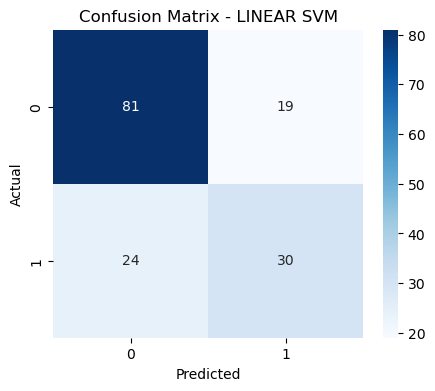

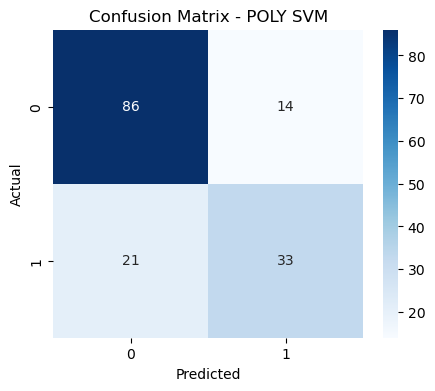

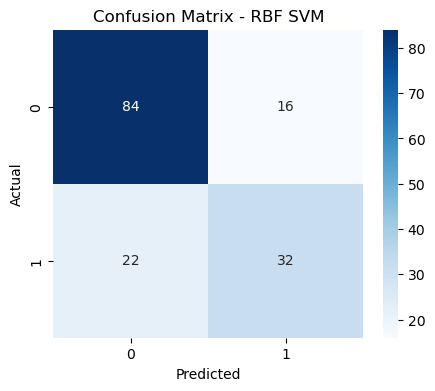

In [67]:
# Function to plot confusion matrix
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Loop through kernels and plot confusion matrices
kernels = ['linear', 'poly', 'rbf']

for kernel in kernels:
    # Get the best parameters for this kernel
    kernel_results = pd.DataFrame(grid_search.cv_results_)
    kernel_results = kernel_results[kernel_results['param_model__kernel'] == kernel]
    if not kernel_results.empty:
        best_idx = kernel_results['mean_test_f1'].idxmax()
        best_params = kernel_results.loc[best_idx, 'params']
        
        # Update pipeline with best params
        best_pipeline = svm_pipeline.set_params(**best_params)
        best_pipeline.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = best_pipeline.predict(X_test)
        
        # Plot confusion matrix
        plot_conf_matrix(y_test, y_pred, title=f'Confusion Matrix - {kernel.upper()} SVM')